# 對 PTT 股票版「台積電」公司進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- matplotlib: 繪圖工具。
- wordcloud: 繪製文字雲工具。
- jieba: 中文斷詞工具。

## 本機使用套間
請先於環境中使用 pip install

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as font_manager
from wordcloud import WordCloud 
import jieba

## colab 使用套件

In [2]:
# Path to the custom font
font_path = 'font/TraditionalChinese.ttf'

# Add the custom font to the font manager
font_manager.fontManager.addfont(font_path)

# After adding the font, search for it by filename to get the correct font name
for font in font_manager.fontManager.ttflist:
    if font.fname == font_path:
        print(f"Found font: {font.name}")
        plt.rcParams['font.family'] = font.name
        break

Found font: Noto Sans TC


## 2. 資料前處理
如 week3 所示  
使用「吃到飽」作為關鍵字，從工作流程系統中將 ptt 資料下載下來

### 2.1 基本資料介紹
- 資料來源: 工作流程蒐集 PTT 股票版 Stock 2023-03-20 ~ 2024-03-20 所有文章

In [3]:
df = pd.read_csv("data/raw_data.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,ATF91,Stock,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""hebeisme5566...",42.77.223.199,2023-03-21 02:21:44,ptt
1,2,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,[新聞]金融存股勇士進場了！9家金控股東人數創,2023-03-20,black1x2y3z,Stock,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\r\n原文連結：\r\nhttps...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""maxdi"", ""cmt...",140.121.145.184,2023-03-21 02:21:44,ptt
2,3,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,[標的]2753八方雲集鍋貼空,2023-03-20,Timzy,Stock,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zxcv91039"", ...",223.141.185.139,2023-03-21 02:21:49,ptt
3,4,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,[情報]0320上市外資買賣超排行,2023-03-20,saber50116,Stock,1. 標題：外資買賣超排行\r\n\r\n2. 來源：台灣證交所\r\n\r\n3. 網址：...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""powerkshs"", ...",111.255.56.173,2023-03-21 02:21:49,ptt
4,5,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,[情報]6667信紘科111年5.11股利4.24,2023-03-20,a0808996,Stock,https://mops.twse.com.tw/mops/web/t146sb05\r\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""PeaceBoy"", ""...",123.194.132.40,2023-03-21 02:21:53,ptt


### 2.2資料清理

In [4]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,1. 標的： 00712 富時不動產\r(例 2330.TW 台積電)\r2. 分類：討論\...
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,[新聞]金融存股勇士進場了！9家金控股東人數創,2023-03-20,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\r\n原文連結：\r\nhttps...,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\r原文連結：\r\r發布時間：20...
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,[標的]2753八方雲集鍋貼空,2023-03-20,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,-\r1.發標的文未充實內文，\r多空理由不充實\r者，板規1-1-5或4-4處份\r2.進...
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,[情報]0320上市外資買賣超排行,2023-03-20,1. 標題：外資買賣超排行\r\n\r\n2. 來源：台灣證交所\r\n\r\n3. 網址：...,1. 標題：外資買賣超排行\r\r2. 來源：台灣證交所\r\r3. 網址：\r\r4. 內...
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,[情報]6667信紘科111年5.11股利4.24,2023-03-20,https://mops.twse.com.tw/mops/web/t146sb05\r\n...,\r1.提報董事會或經董事會決議日期:112/03/20\r2.審計委員會通過日期:112/...
...,...,...,...,...,...
2770,https://www.ptt.cc/bbs/Stock/M.1710843746.A.03...,[標的]ADM.US,2024-03-19,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,-\r1.發標的文未充實內文，\r多空理由不充實\r者，板規1-1-5或4-4處份\r2.進...
2771,https://www.ptt.cc/bbs/Stock/M.1710851717.A.B6...,[新聞]賴清德向竹科半導體業掛保證維持兩岸和,2024-03-19,原文標題：\r\n賴清德向竹科半導體業掛保證 維持兩岸和平「水電不用擔心」\r\n\r\n原...,原文標題：\r賴清德向竹科半導體業掛保證 維持兩岸和平「水電不用擔心」\r\r原文連結：\r...
2772,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,1. 標題：113年03月19日信用交易統計\r2. 來源：臺灣證券交易所、證券櫃檯買賣中心...
2773,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,[情報]0319上市櫃外資投信買超金額排行,2024-03-19,外資\r\n\r\n排行 股票名稱 百萬 收盤價 漲跌\r\n\r\n1 ...,外資\r\r排行 股票名稱 百萬 收盤價 漲跌\r\r1 2317...


斷句

In [5]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,1. 標的： 00712 富時不動產\r(例 2330.TW 台積電)\r2. 分類：討論\...
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,股價卻沒有急速下跌
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,是每天凌遲你那種小小跌
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,明\r天除息0.24
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,整年殖利率可能有9趴以上
...,...,...,...,...,...
83389,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,802 張\r券增 9 張\r2404漢唐\r資增 790 ...
83390,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,011 張\r券增 183 張\r=====================...
83391,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,941 張\r券增 116 張
83392,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,[情報]0319上市櫃外資投信買超金額排行,2024-03-19,外資\r\n\r\n排行 股票名稱 百萬 收盤價 漲跌\r\n\r\n1 ...,外資\r\r排行 股票名稱 百萬 收盤價 漲跌\r\r1 2317...


In [6]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt

jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from C:\Users\eddie\GitHub\StockNatrakLanguageAnalyze\dict\dict.txt ...
Loading model from cache C:\Users\eddie\AppData\Local\Temp\jieba.u7ed60b131b91313bb12d624d6950b4ca.cache
Loading model cost 0.528 seconds.
Prefix dict has been built successfully.


In [7]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的 富時不動產\r例 TW 台積電\r 分類討論\r\r 分析正文\r\r這隻已經超過...
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,股價卻沒有急速下跌
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,是每天凌遲你那種小小跌
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,明\r天除息
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,整年殖利率可能有趴以上
...,...,...,...,...,...
83389,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,張\r券增 張\r漢唐\r資增 張\r券增 ...
83390,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,張\r券增 張\r\r櫃買信用交易統計\r資增 億\r券增 ...
83391,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,張\r券增 張
83392,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,[情報]0319上市櫃外資投信買超金額排行,2024-03-19,外資\r\n\r\n排行 股票名稱 百萬 收盤價 漲跌\r\n\r\n1 ...,外資\r\r排行 股票名稱 百萬 收盤價 漲跌\r\r 鴻海 ...


### 2.3 文章斷詞

In [8]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,富時
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,不動產
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,TW
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,台積電
...,...,...,...,...,...
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,JPTT
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,on
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,my
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,Samsung


移除停用字

In [9]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 
stopwords_manual = ["原文", "標題", "今年", "來源", "公司", "評論", "署名", "內容時間", "現在", "連結", "目前", "股票",
                    "股價", "台積電", "台積", "台股", "台灣", "台灣股市", "台灣股票", "台灣股價", "台灣股票市場",
                    "台灣股市", "內容", "評論", "文章", "內文", "記者", "指出", "心得", "來源", "市場", "表示", "去年",
                    "預期", "億元", "TW", "持續", "未來", "產業", "券增", "排行", "證券", "今天", "報導", "分類",
                    "網址", "時間", "客戶", "認為", "討論", "張數", "相關", "影響", "機制", "億美元", "美元", "企業",
                    "金額", "資料", "發布", "格式", "投資"]
stopwords.extend(stopwords_manual)

In [10]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,富時
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,不動產
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,分析
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,正文
...,...,...,...,...,...
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,JPTT
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,on
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,my
83393,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,[標的]6667信紘科海外擴大營運多,2024-03-19,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,Samsung


## 3. Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

In [11]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [12]:
liwc_dict['sentiments'].describe()

count       4715
unique         6
top       affect
freq        2061
Name: sentiments, dtype: object

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

```merge function 介紹```
https://www.delftstack.com/zh-tw/howto/python-pandas/merge-dataframes-on-index-in-pandas/

In [13]:
ptt_liwc_df = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的,NaN
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,富時,NaN
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,不動產,NaN
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,分析,NaN
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,正文,NaN
...,...,...,...,...,...,...
366251,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,2024-03-19,[標的]6667信紘科海外擴大營運多,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,JPTT,NaN
366252,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,2024-03-19,[標的]6667信紘科海外擴大營運多,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,on,NaN
366253,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,2024-03-19,[標的]6667信紘科海外擴大營運多,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,my,NaN
366254,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,2024-03-19,[標的]6667信紘科海外擴大營運多,1. 標的： 6667 信紘科\r\n\r\n2. 分類：多/空/請益/心得\r\n\r\n...,Samsung,NaN


### 3.3 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

```情緒分析指標```
在情緒分析中，我們會以不同的指標來看情緒的好壞，其中常見的包含：
1. **情感詞彙頻率**： 使用情感詞彙列表，其中包含正向和負向情感的詞彙。將文本中的詞與該列表進行匹配，計算正向和負向詞彙的出現次數，從而判斷整體情感傾向。
2. **情感詞彙比例**：不同於單純的計算頻率，比例是某種情緒（例如：正向）佔所有情緒詞中的幾分之幾。這種方法可以避免某一天文章數特別多（詞頻也會隨之變多）而影響情緒的判斷。
2. **情感詞彙分數**： 給每個情感詞彙分配一個權重或分數，然後計算文本中所有情感詞的總分。這種方法允許區分不同情感詞的影響力，進一步細化情感分析的結果。

我們先以最基本的詞頻來計算

```groupby function 介紹```https://zhuanlan.zhihu.com/p/101284491

In [14]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
3,2023-03-20,negative,18
4,2023-03-20,positive,12
9,2023-03-21,negative,55
10,2023-03-21,positive,57
15,2023-03-22,negative,27
...,...,...,...
1716,2024-03-17,positive,17
1721,2024-03-18,negative,51
1722,2024-03-18,positive,74
1727,2024-03-19,negative,20


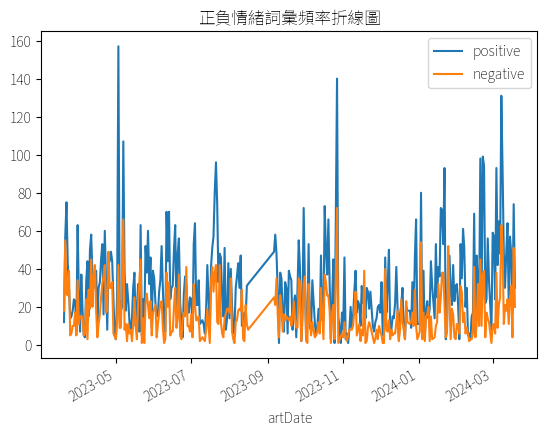

In [15]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖")  # 記得加上才能顯示中文
plt.show()

```Moving average```
- rolling average（滾動平均）是一種將時間序列數據平滑化的技術，有助於去除數據中的噪聲，使趨勢更加明顯，同時仍然保留一定的時間特徵。
- 在情緒分析中，特別是當你有一系列時間序列的情緒數據時，使用滾動平均有助於平滑數據，使情緒趨勢更加清晰。
    1. **去除瞬間噪聲**： 情緒數據可能受到瞬間事件或噪聲的影響，例如突發的大量評論或新聞。滾動平均有助於平滑這些突變，使你更容易觀察到整體趨勢。
    2. **強調長期趨勢**： 滾動平均有助於強調長期情緒趨勢，而不受短期波動的干擾。這對於觀察情緒的漸變和長期變化非常有用。


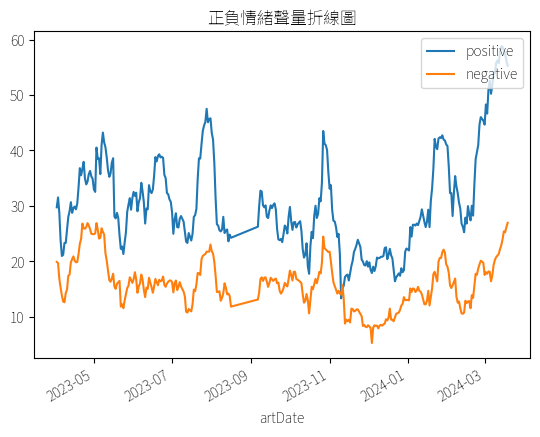

In [16]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖")  # 記得加上才能顯示中文
plt.show()

畫出每天的情緒總分數，可以看到正面的詞出現頻率幾乎每天都超過負面，是個氣氛和諧的討論版。

```詞頻缺點```

如果某一天有什麼事件發生而導致正負向詞頻數隨之飆高，在趨勢圖看來可能會認為該區間的正負向情緒較為顯著，但也有可能是因為總體情緒詞彙本來就比較多而導致的。

以比例的方式來看，我們可以觀察到某個情緒詞在總體情緒詞彙中所佔的比例，就算某一天文章數相較多，也不會影響到比例的呈現。

### 3.4 正負向情緒詞彙比例折線圖圖

```lambda```函式是一種匿名函式，包含以下幾點特性：

+ 不需要定義函式名稱
+ 只能有一行運算式
+ 執行完後會自動回傳結果，不需要return   

因此```lambda```適合在該函式只有單行運算式且不會被重複呼叫時使用

參考網址：   
[Python Lambda](https://www.w3schools.com/python/python_lambda.asp)   
[Lambda — Python 重要語法技巧](https://medium.com/johnliu-的軟體工程思維/lambda-python-重要語法技巧-27c467ddfa16)

In [17]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
3,2023-03-20,negative,18,0.600000
4,2023-03-20,positive,12,0.400000
9,2023-03-21,negative,55,0.491071
10,2023-03-21,positive,57,0.508929
15,2023-03-22,negative,27,0.264706
...,...,...,...,...
1716,2024-03-17,positive,17,0.809524
1721,2024-03-18,negative,51,0.408000
1722,2024-03-18,positive,74,0.592000
1727,2024-03-19,negative,20,0.400000


In [18]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

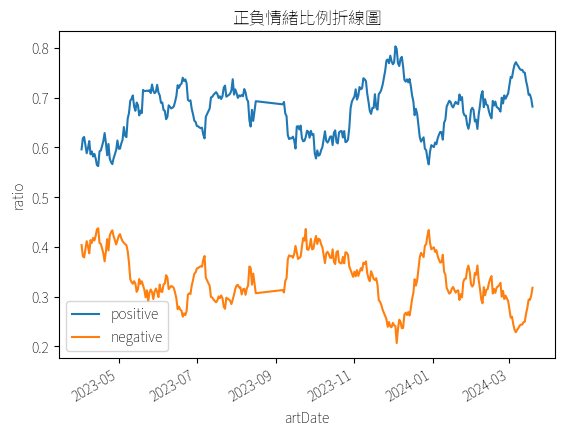

In [19]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 正負向情緒分數折線圖

In [20]:
sentiment_count

,artDate,sentiments,size,ratio
3,2023-03-20,negative,18,0.600000
4,2023-03-20,positive,12,0.400000
9,2023-03-21,negative,55,0.491071
10,2023-03-21,positive,57,0.508929
15,2023-03-22,negative,27,0.264706
...,...,...,...,...
1716,2024-03-17,positive,17,0.809524
1721,2024-03-18,negative,51,0.408000
1722,2024-03-18,positive,74,0.592000
1727,2024-03-19,negative,20,0.400000


In [21]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,negative,positive
0,2023-03-20,18.0,12.0
1,2023-03-21,55.0,57.0
2,2023-03-22,27.0,75.0
3,2023-03-23,26.0,43.0
4,2023-03-24,39.0,31.0


In [22]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

,artDate,negative,positive,sentiment_value
0,2023-03-20,18.0,12.0,-6.0
1,2023-03-21,55.0,57.0,2.0
2,2023-03-22,27.0,75.0,48.0
3,2023-03-23,26.0,43.0,17.0
4,2023-03-24,39.0,31.0,-8.0


Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

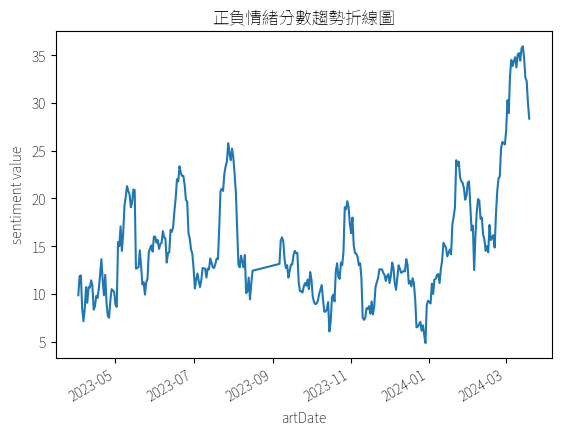

In [23]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.6 文章為單位的情緒分析

In [24]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

,artUrl,sentiments,size
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,affect,2
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,negative,1
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,positive,1
3,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,affect,5
4,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,negative,1
...,...,...,...
7214,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,affect,1
7215,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,positive,1
7216,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,affect,5
7217,https://www.ptt.cc/bbs/Stock/M.1710863318.A.22...,negative,1


In [25]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2.0,0.0,0.0,1.0,1.0,0.0
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,5.0,0.0,0.0,1.0,4.0,1.0
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,4.0,1.0,0.0,2.0,2.0,0.0
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,1.0,0.0,0.0,0.0,1.0,0.0
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,4.0,2.0,0.0,3.0,0.0,2.0


In [26]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2.0,0.0,0.0,1.0,1.0,0.0,0.0
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,5.0,0.0,0.0,1.0,4.0,1.0,3.0
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,4.0,1.0,0.0,2.0,2.0,0.0,0.0
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,4.0,2.0,0.0,3.0,0.0,2.0,-3.0


In [27]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

,artUrl,affect,anger,anx,negative,positive,sad,sentiment_value,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2.0,0.0,0.0,1.0,1.0,0.0,0.0,負向
1,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,5.0,0.0,0.0,1.0,4.0,1.0,3.0,正向
2,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,4.0,1.0,0.0,2.0,2.0,0.0,0.0,負向
3,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向
4,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,4.0,2.0,0.0,3.0,0.0,2.0,-3.0,負向
...,...,...,...,...,...,...,...,...,...
2278,https://www.ptt.cc/bbs/Stock/M.1710830890.A.CE...,12.0,3.0,3.0,11.0,4.0,0.0,-7.0,負向
2279,https://www.ptt.cc/bbs/Stock/M.1710843746.A.03...,2.0,0.0,0.0,1.0,0.0,0.0,-1.0,負向
2280,https://www.ptt.cc/bbs/Stock/M.1710851717.A.B6...,26.0,0.0,3.0,7.0,19.0,0.0,12.0,正向
2281,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,正向


In [28]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentiment_class
0,1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,ATF91,Stock,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""hebeisme5566...",42.77.223.199,2023-03-21 02:21:44,ptt,負向
1,2,https://www.ptt.cc/bbs/Stock/M.1679289787.A.D6...,[新聞]金融存股勇士進場了！9家金控股東人數創,2023-03-20,black1x2y3z,Stock,原文標題：金融存股勇士進場了！9家金控股東人數創史上新高\r\n原文連結：\r\nhttps...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""maxdi"", ""cmt...",140.121.145.184,2023-03-21 02:21:44,ptt,正向
2,3,https://www.ptt.cc/bbs/Stock/M.1679292328.A.BC...,[標的]2753八方雲集鍋貼空,2023-03-20,Timzy,Stock,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zxcv91039"", ...",223.141.185.139,2023-03-21 02:21:49,ptt,負向
3,4,https://www.ptt.cc/bbs/Stock/M.1679299901.A.73...,[情報]0320上市外資買賣超排行,2023-03-20,saber50116,Stock,1. 標題：外資買賣超排行\r\n\r\n2. 來源：台灣證交所\r\n\r\n3. 網址：...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""powerkshs"", ...",111.255.56.173,2023-03-21 02:21:49,ptt,正向
4,5,https://www.ptt.cc/bbs/Stock/M.1679304839.A.E6...,[情報]6667信紘科111年5.11股利4.24,2023-03-20,a0808996,Stock,https://mops.twse.com.tw/mops/web/t146sb05\r\n...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""PeaceBoy"", ""...",123.194.132.40,2023-03-21 02:21:53,ptt,負向
...,...,...,...,...,...,...,...,...,...,...,...,...
2770,2771,https://www.ptt.cc/bbs/Stock/M.1710843746.A.03...,[標的]ADM.US,2024-03-19,yamakazi,Stock,-\r\n1.發標的文未充實內文，\r\n多空理由不充實\r\n者，板規1-1-5或4-4處...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""gs13010"", ""c...",1.200.104.88,2024-03-20 02:05:23,ptt,負向
2771,2772,https://www.ptt.cc/bbs/Stock/M.1710851717.A.B6...,[新聞]賴清德向竹科半導體業掛保證維持兩岸和,2024-03-19,humbler,Stock,原文標題：\r\n賴清德向竹科半導體業掛保證 維持兩岸和平「水電不用擔心」\r\n\r\n原...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""nvlsvee"", ""c...",111.251.205.175,2024-03-20 02:05:27,ptt,正向
2772,2773,https://www.ptt.cc/bbs/Stock/M.1710856327.A.44...,[情報]113年03月19日信用交易統計,2024-03-19,steward135,Stock,1. 標題：113年03月19日信用交易統計\r\n2. 來源：臺灣證券交易所、證券櫃檯買賣...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hong92"", ""cm...",36.224.121.61,2024-03-20 02:05:31,ptt,NaN
2773,2774,https://www.ptt.cc/bbs/Stock/M.1710862323.A.84...,[情報]0319上市櫃外資投信買超金額排行,2024-03-19,steveisaman,Stock,外資\r\n\r\n排行 股票名稱 百萬 收盤價 漲跌\r\n\r\n1 ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""fernmmm"", ""c...",36.234.75.22,2024-03-20 02:05:31,ptt,正向


In [29]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

,artDate,sentiment_class,size
0,2023-03-20,正向,3
1,2023-03-20,負向,6
2,2023-03-21,正向,11
3,2023-03-21,負向,3
4,2023-03-22,正向,10
...,...,...,...
602,2024-03-17,負向,2
603,2024-03-18,正向,10
604,2024-03-18,負向,8
605,2024-03-19,正向,3


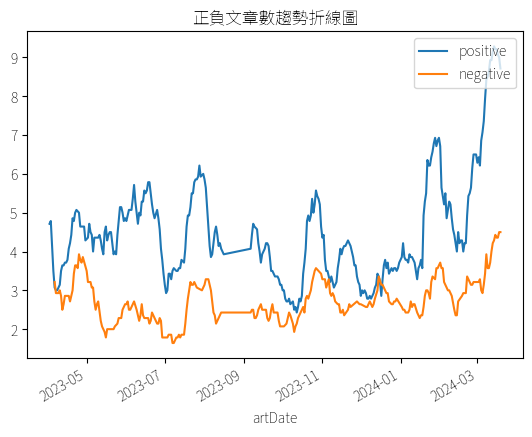

In [30]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖")  # 記得加上才能顯示中文
plt.show()

大部分文章都被歸類在正向文章，股票台積電版討論內容大多偏正面

### 3.7 情緒代表字

In [31]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
1271,獲利,positive,608
383,問題,affect,562
384,問題,negative,562
992,智慧,affect,384
993,智慧,positive,384
...,...,...,...
1348,眼淚,negative,1
1349,眼淚,sad,1
1350,眼花撩亂,affect,1
1351,眼花撩亂,negative,1


In [32]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

,word,sentiments,size
1271,獲利,positive,608
993,智慧,positive,384
1723,重要,positive,334
1391,突破,positive,260
332,受惠,positive,236
608,希望,positive,235
1609,謝謝,positive,206
995,智能,positive,192
1783,領先,positive,179
679,復甦,positive,177


In [33]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

,word,sentiments,size
384,問題,negative,562
1564,衰退,negative,316
1791,風險,negative,295
460,壓力,negative,284
1553,虧損,negative,248
1656,跌停,negative,199
1747,降低,negative,136
1657,跌破,negative,132
937,擔心,negative,116
99,低迷,negative,88


C:\Users\eddie\AppData\Local\Temp\ipykernel_19352\1734313141.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\eddie\AppData\Local\Temp\ipykernel_19352\1734313141.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

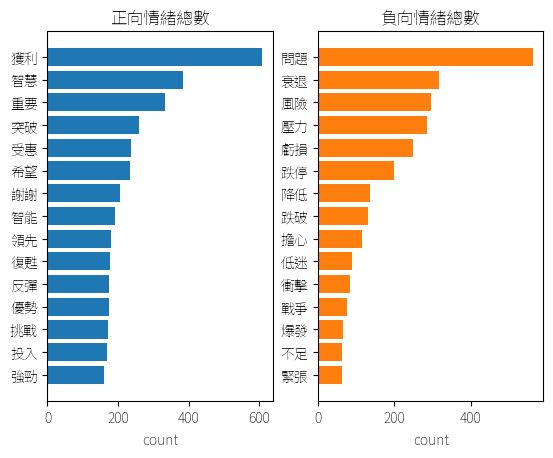

In [34]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 檢查情緒詞是否符合本文本

In [35]:
filtered_df = sent_df[sent_df['sentence'].str.contains('挑戰', na=False)]
filtered_df.head()

,artUrl,artTitle,artDate,artContent,sentence
1782,https://www.ptt.cc/bbs/Stock/M.1679583369.A.63...,[標的]Nasdaq強襲魔女集結,2023-03-23,1. 標的： 美股 Nasdaq\r\n(例 2330.TW 台積電)\r\n2. 分類：...,所以同時間納指應該會挑戰\r但我個人傾向在月中以前必定要完成上述這個過程\r之後納指一定要死守
1784,https://www.ptt.cc/bbs/Stock/M.1679583369.A.63...,[標的]Nasdaq強襲魔女集結,2023-03-23,1. 標的： 美股 Nasdaq\r\n(例 2330.TW 台積電)\r\n2. 分類：...,這樣七月前納指才能挑戰小納挑戰\r\r如果整體量能不想這樣發展
2310,https://www.ptt.cc/bbs/Stock/M.1679740588.A.7A...,[新聞]華為：完成14奈米以上EDA工具國產化,2023-03-25,美斷供「晶片之母」後突圍！華為：完成 14 奈米以上 EDA 工具國產化\r\nhttps:...,但仍面臨艱巨挑戰
3954,https://www.ptt.cc/bbs/Stock/M.1680495138.A.EE...,[新聞]英特爾新世代GPU台積電全吃,2023-04-03,原文標題：\r\n英特爾新世代GPU 台積電全吃\r\n\r\n原文連結：\r\nhttps...,營運面臨較大挑戰
4763,https://www.ptt.cc/bbs/Stock/M.1680912397.A.93...,[新聞]一週熱門零股國泰永續高股息最搶手,2023-04-08,原文標題：一周熱門零股／國泰永續高股息 最搶手\r\n\r\n原文連結：\r\nhttps:...,短線仍\r有挑戰萬六的機會


In [36]:
for sentence in filtered_df['sentence'].to_list():
    print(sentence)
    print("=========================")

之後納指一定要死守以前必定要完成上述這個過程
如果整體量能不想這樣發展納挑戰
但仍面臨艱巨挑戰
營運面臨較大挑戰
有挑戰萬六的機會
供應鏈傳出濟日報 記者李珣瑛挑戰
成本與人才將是兩項艱鉅的挑戰
震盪趨堅挑戰萬六關卡
不以挑戰萬六關卡為滿足
顯示對台股向上挑戰萬七有一定信心
讓系統單晶片SoC在功耗性能和可靠性上能應對日益增加的設計挑戰
亞利桑那州廠儘管執照取得上存在一些挑戰
  現在台積電絕對不貴付未來中美晶片戰爭的危機與海外擴廠可能遇到的未知挑戰
挑戰萬六以上機率仍高
片的挑戰性比生產裝置還高
屢屢挑戰萬六大關失敗
台股挑戰萬六數度碰壁
進行了一些討論的一些挑戰
並面臨建立可持續商業模式的挑戰
但五大商社業務都得要看大宗商品的臉色
看好台股有機會挑戰
台股有機會向上挑戰
台積電在量產奈米晶片過程中有不少挑戰
同時年全年對於半導體業者來說則是具有挑戰的一年
不但帶領台積電大漲挑戰前高
挑戰四百成功
NVIDIA大漲不僅帶動台積電挑戰前高
股價皆挑戰波段新高
成為引領台股挑戰萬七
的價位站穩應該能挑戰去年
日股挑戰高點反映兩大重點
台積電過去幾年經歷許多挑戰
台積電過去幾年經歷不少挑戰
台積電在過去幾年經歷許多挑戰
台積電經歷過去許多的挑戰
氣候變遷等許多挑戰歷美中貿易戰疫情烏俄戰爭
不僅在消費級產品有挑戰英特爾之勢
準備再次挑戰NVIDIA
隨著超微AI大會登場並蓄勢挑戰輝達
有望挑戰賺贏去年一整年的表現
今年營收獲利挑戰歷史巔峰
 年對晶圓代工廠是非常挑戰的一年
支平衡對公司來說也是一個很大的挑戰
期間橫跨年的網路時代年智慧型手機時代
淨零轉型是商機也是挑戰
至於市場的二大風險為進入除息旺季點數蒸發財報公告形成挑戰
年來佔據晶圓代工市場主導地位的台積電和三星
挑戰電和三星可能會面臨重大
也凸顯台積電海外擴張面臨的挑戰
不僅突顯台積電海外擴張面臨的挑戰
在陌生的環境與外國建築工人溝通具有挑戰性
帶來的挑戰特爾進軍代工市場所
台積電盛夏挑戰元大關
全年營收有機會挑戰億元
幾乎是爆炸性成長營收要高達億
在技術上面臨挑戰
逢台股飆漲攻上萬七挑戰萬八大關
在技術上具挑戰性
臨挑戰因是在於美國和印度之間劃分和協調工作面
非長期投資者之前的xxx張還少 只有xxx張
第三次挑戰該上了吧
會挑戰有機
而如果升息一碼給你挑戰那斯達克指數生更大的上爬力道
尤其無論怎樣率影響很大反觀

#### 重新計算情緒

控制、問題、擔心、錯過、隨便、強烈、負擔、口吃、挑剔、壓力、邪惡、禁止、挑戰、謝謝、智能、智慧

In [37]:
# 設定要移除的字詞列表
words_to_remove = ['問題', '控制', '擔心', '錯過', '隨便', '強烈', '負擔', '口吃', '挑剔', '壓力', '邪惡', '禁止',
                   '挑戰', '謝謝', '智能', '智慧']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(noStop_df[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict_revise,
                              how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的,NaN
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,富時,NaN
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,不動產,NaN
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,分析,NaN
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,正文,NaN


C:\Users\eddie\AppData\Local\Temp\ipykernel_19352\2371119238.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"])
C:\Users\eddie\AppData\Local\Temp\ipykernel_19352\2371119238.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

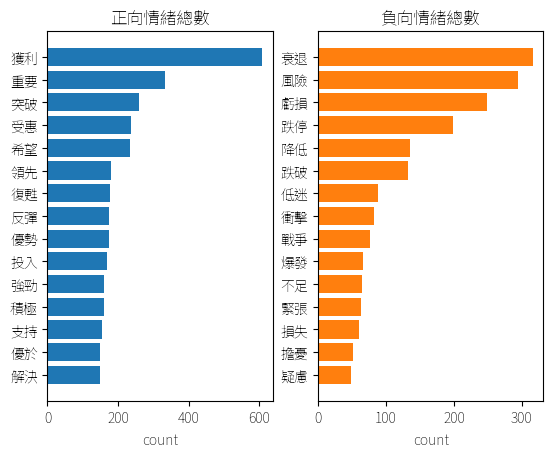

In [38]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

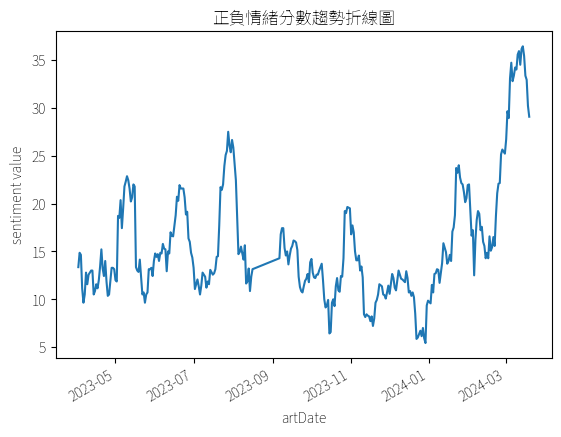

In [39]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖")

### 3.8 文字雲
如果文字雲中的字詞大小越大，代表出現頻率越高

#### 2023-10-15 ~2023-11-01 文字雲
2023-10-15 ~2023-11-01 在情緒分數趨勢圖上顯示比較低的分數，我們用文字雲來看一下這段時間出現了什麼關鍵字

將前面計算出的文章情緒類別合併，以利我們過濾出負面文章資料

In [40]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的,NaN,負向
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,富時,NaN,負向
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,不動產,NaN,負向
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,分析,NaN,負向
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,2023-03-20,[標的]00712富時不動產天天大溢價要賣？,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,正文,NaN,負向


In [41]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df.head()

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
0,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,標的 富時不動產\r例 TW 台積電\r 分類討論\r\r 分析正文\r\r這隻已經超過...,負向
1,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,股價卻沒有急速下跌,負向
2,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,是每天凌遲你那種小小跌,負向
3,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,明\r天除息,負向
4,https://www.ptt.cc/bbs/Stock/M.1679279576.A.D7...,[標的]00712富時不動產天天大溢價要賣？,2023-03-20,1. 標的： 00712 富時不動產\r\n(例 2330.TW 台積電)\r\n2. 分類...,整年殖利率可能有趴以上,負向


In [42]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask]
ptt_df_wc

,artUrl,artDate,artTitle,artContent,word,sentiments,sentiment_class
201090,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,詐騙,affect,負向
201091,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,詐騙,negative,負向
201092,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,詐騙,anger,負向
201093,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,廣告,NaN,負向
201094,https://www.ptt.cc/bbs/Stock/M.1697371888.A.94...,2023-10-15,[新聞]詐騙廣告平台24小時不下架立即罰,原文標題：\r\n\r\n詐騙廣告 平台24小時不下架立即罰\r\n\r\n原文連結：\r\...,平台,NaN,負向
...,...,...,...,...,...,...,...
219423,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,股利,NaN,負向
219424,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,零用錢,NaN,負向
219425,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,乖乖,NaN,負向
219426,https://www.ptt.cc/bbs/Stock/M.1698801603.A.A8...,2023-11-01,[新聞]愈跌愈護！八大官股券商認真買！13個交易,原文標題：愈跌愈護！八大官股券商認真買！ 13個交易日砸近270億愛台股\r\nhttps:...,爆發,affect,負向


In [43]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & (
    ptt_liwc_df_revise['sentiment_class'] == "負向")

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

,word,size
1729,美債,46
171,下跌,34
1850,衝突,33
1974,賣超,32
1731,美國,31
...,...,...
1365,殞落,1
234,之稱,1
706,士開,1
1362,歸來,1


(-0.5, 399.5, 199.5, -0.5)

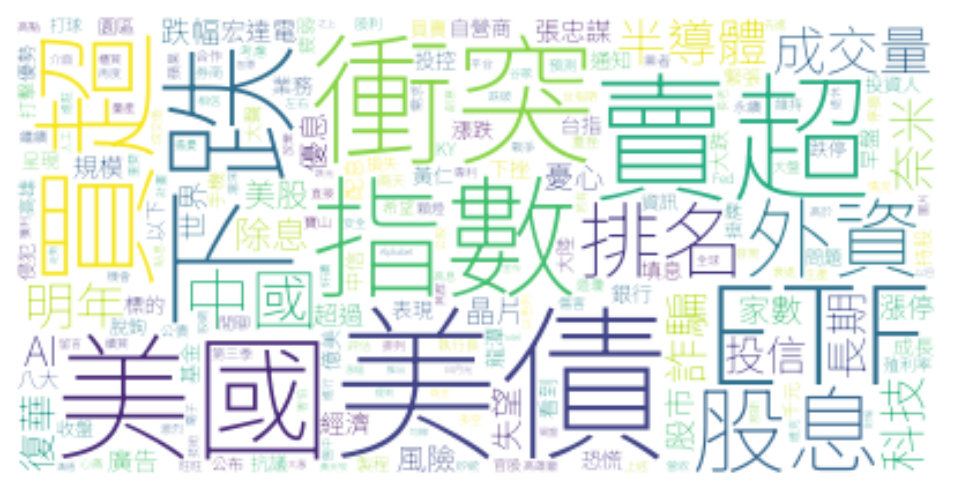

In [44]:
# wordcloud 的 input 是 dictionary
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

關鍵字出現了「美債」、「AI」、「賣超」、「衝突」、「下跌」的關鍵字，可能是在說明美債導致台積電下跌

(-0.5, 399.5, 199.5, -0.5)

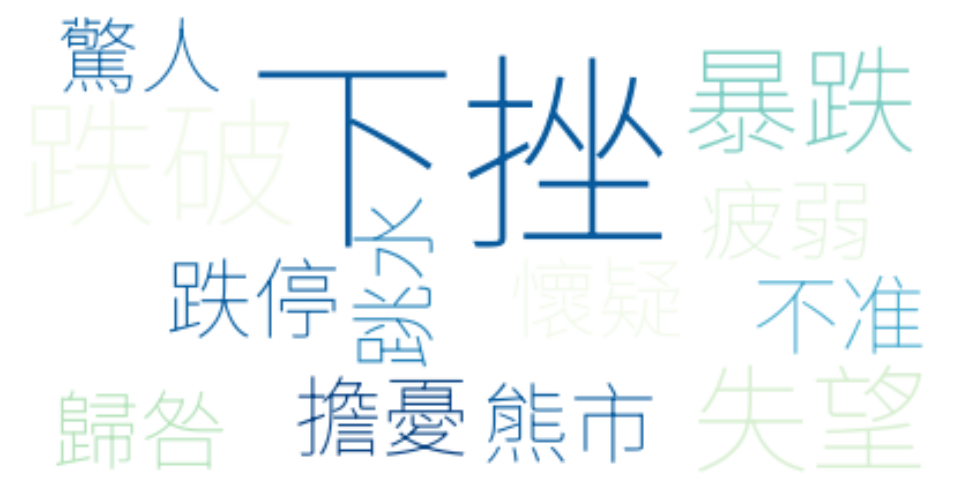

In [45]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (ptt_liwc_df_revise['artDate'] >= pd.Timestamp(date).date()) & (
    ptt_liwc_df_revise['artDate'] <= pd.Timestamp(end_date).date()) & ( # 時間區間
    ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('美債')) & ( # 內文包含美債
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

利用「下挫」去查看原文內容

In [53]:
date = "2023-10-15"
end_date = "2023-11-01"
mask = (sent_df['artDate'] >= pd.Timestamp(date).date()) & (
    sent_df['artDate'] <= pd.Timestamp(end_date).date()) & (
    sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('美債')) & (
    sent_df['sentence'].str.contains('下挫')) # 包含「下挫」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df

,artUrl,artTitle,artDate,artContent,sentence,sentiment_class
44922,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,引發投資人擔憂聯準會Fed可能將利率維持在高檔更久,負向
44923,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,並可能再度升息,負向
44924,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r同\r時,負向
44925,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r道瓊工業指數早盤跌近百點或,負向
44926,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,標普指數和那斯達克綜合指數各跌和,負向
44927,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r費城半導體指數下挫,負向
44928,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,台積電ADR也跌,負向
44929,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,\r\r美國月整體零售銷售月增,負向
44930,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,遠高於預估的增幅,負向
44931,https://www.ptt.cc/bbs/Stock/M.1697552603.A.1D...,[新聞]美擴大限制輝達晶片銷陸輝達早盤急挫6%,2023-10-17,原文標題：美擴大限制輝達晶片銷陸 輝達早盤急挫6%\r\n\r\n原文連結：\r\nhttp...,扣除汽車之後的核心銷售額比\r月增加,負向


文章中提到了台股重挫，道瓊指數下跌